<a href="https://colab.research.google.com/github/Sudeeppp-Mishra/LeafLens/blob/main/LeafLens_Train_on_DataSets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

# Attempt to unmount first to clear any existing state
drive.flush_and_unmount()

# Ensure the mount point directory is empty or doesn't exist
# This step forcefully removes the directory if it contains files
# and is a common workaround for persistent mountpoint issues.
if os.path.exists('/content/drive'):
    !rm -rf /content/drive

# Then mount with force_remount
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
DATASET_DIR = "/content/drive/MyDrive/datasets/PlantVillage"

selected_classes = [
    'Tomato_healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]

class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
num_classes = len(selected_classes)

In [5]:
image_paths = []
labels = []

for cls in selected_classes:
    cls_path = os.path.join(DATASET_DIR, cls)
    for img in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, img))
        labels.append(class_to_idx[cls])

print("Total images:", len(image_paths))
print("Classes:", num_classes)

Total images: 18419
Classes: 13


In [6]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [7]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
class SafePlantDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]

        try:
            image = cv2.imread(path)

            # 🔴 VERY IMPORTANT CHECK
            if image is None:
                raise ValueError(f"Corrupted image: {path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image)

            return image, self.labels[idx]

        except Exception as e:
            # Skip bad image safely
            return self.__getitem__((idx + 1) % len(self.paths))

In [9]:
train_loader = DataLoader(
    SafePlantDataset(train_paths, train_labels, train_transform),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    SafePlantDataset(val_paths, val_labels, val_transform),
    batch_size=32,
    shuffle=False
)

In [10]:
from torchvision.models import EfficientNet_B0_Weights

model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 165MB/s]


In [11]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [12]:
import torch
from tqdm import tqdm
import os

# =========================
# PARAMETERS
# =========================
epochs = 15
checkpoint_dir = "/content/drive/MyDrive/checkpoints_newww"
os.makedirs(checkpoint_dir, exist_ok=True)

# =========================
# MANUAL CHECKPOINT PATH
# =========================
# 👉 Set this to None to start fresh
# 👉 Or set to a checkpoint path to resume
resume_checkpoint = "/content/drive/MyDrive/checkpoints_newww/checkpoint_epoch11.pth"
# example:
# resume_checkpoint = "/content/drive/MyDrive/checkpoints_newww/checkpoint_epoch7.pth"

start_epoch = 0

# =========================
# RESUME LOGIC (FIXED)
# =========================
if resume_checkpoint is not None and os.path.exists(resume_checkpoint):
    print(f"✅ Found checkpoint: {resume_checkpoint}")

    checkpoint = torch.load(resume_checkpoint, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    start_epoch = checkpoint["epoch"] + 1  # move to next epoch
    print(f"🔄 Resuming from Epoch {start_epoch + 1}")

else:
    print("🚀 Starting training from Epoch 1")

# =========================
# TRAINING LOOP
# =========================
for epoch in range(start_epoch, epochs):

    model.train()
    running_loss = 0.0

    print(f"\n🌱 Epoch {epoch + 1}/{epochs}")
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"📉 Training Loss Epoch {epoch + 1}: {avg_loss:.4f}")

    # =========================
    # SAVE CHECKPOINT
    # =========================
    checkpoint_path = os.path.join(
        checkpoint_dir, f"checkpoint_epoch{epoch + 1}.pth"
    )

    torch.save({
        "epoch": epoch,  # zero-indexed
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, checkpoint_path)

    print(f"💾 Checkpoint saved: {checkpoint_path}")


✅ Found checkpoint: /content/drive/MyDrive/checkpoints_newww/checkpoint_epoch11.pth
🔄 Resuming from Epoch 12

🌱 Epoch 12/15


📉 Training Loss Epoch 12: 0.0125
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints_newww/checkpoint_epoch12.pth

🌱 Epoch 13/15


📉 Training Loss Epoch 13: 0.0131
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints_newww/checkpoint_epoch13.pth

🌱 Epoch 14/15


📉 Training Loss Epoch 14: 0.0118
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints_newww/checkpoint_epoch14.pth

🌱 Epoch 15/15


📉 Training Loss Epoch 15: 0.0132
💾 Checkpoint saved: /content/drive/MyDrive/checkpoints_newww/checkpoint_epoch15.pth


In [13]:
# =========================
# SAVE FINAL TRAINED MODEL
# =========================
final_model_path = "/content/drive/MyDrive/checkpoints_newww/final_trained_model.pth"

torch.save(model.state_dict(), final_model_path)

print(f"🎉 Final trained model saved at: {final_model_path}")


🎉 Final trained model saved at: /content/drive/MyDrive/checkpoints_newww/final_trained_model.pth


In [14]:
# Save the entire trained model (architecture + learned weights) to a file.
# This includes:
# 1. The model structure (all layers, configurations, etc.).
# 2. The trained parameters (weights and biases) learned during training.
# Saving the full model like this allows you to load it later without
# redefining the architecture, making it ready for inference in scripts
# or GUI applications (like PySide6) directly.

torch.save(model, "/content/drive/MyDrive/checkpoints_newww/final_trained_model_full.pth")
print(f"Final full model saved in drive!")

Final full model saved in drive!


In [15]:
import pickle

class_names = [
    'Tomato_healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]  # your class list

with open("/content/drive/MyDrive/checkpoints/class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)
print("Class names saved to Drive")


Class names saved to Drive


In [16]:
import torch
from torchvision import transforms
from PIL import Image
import pickle

# 1️⃣ Load your trained model
model = efficientnet_b0(num_classes=13)
model.load_state_dict(torch.load("/content/drive/MyDrive/checkpoints/final_trained_model_full.pth"))
model.eval()  # set to evaluation mode

# 2️⃣ Load your class names
with open("/content/drive/MyDrive/checkpoints/class_names.pkl", "rb") as f:
    class_names = pickle.load(f)

# 3️⃣ Prepare the image
image_path = "/content/drive/MyDrive/datasets/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG"  # example image
image = Image.open(image_path).convert("RGB")

# Apply same transforms as during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # resize as per your model input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet normalization if used
                         [0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0)  # add batch dimension

# 4️⃣ Run inference
with torch.no_grad():
    output = model(image_tensor)
    pred_index = torch.argmax(output, dim=1).item()
    pred_class = class_names[pred_index]

print(f"Predicted class: {pred_class}")


NameError: name 'efficientnet_b0' is not defined


📊 Validation Loss: 0.0378
🎯 Validation Accuracy: 99.08%


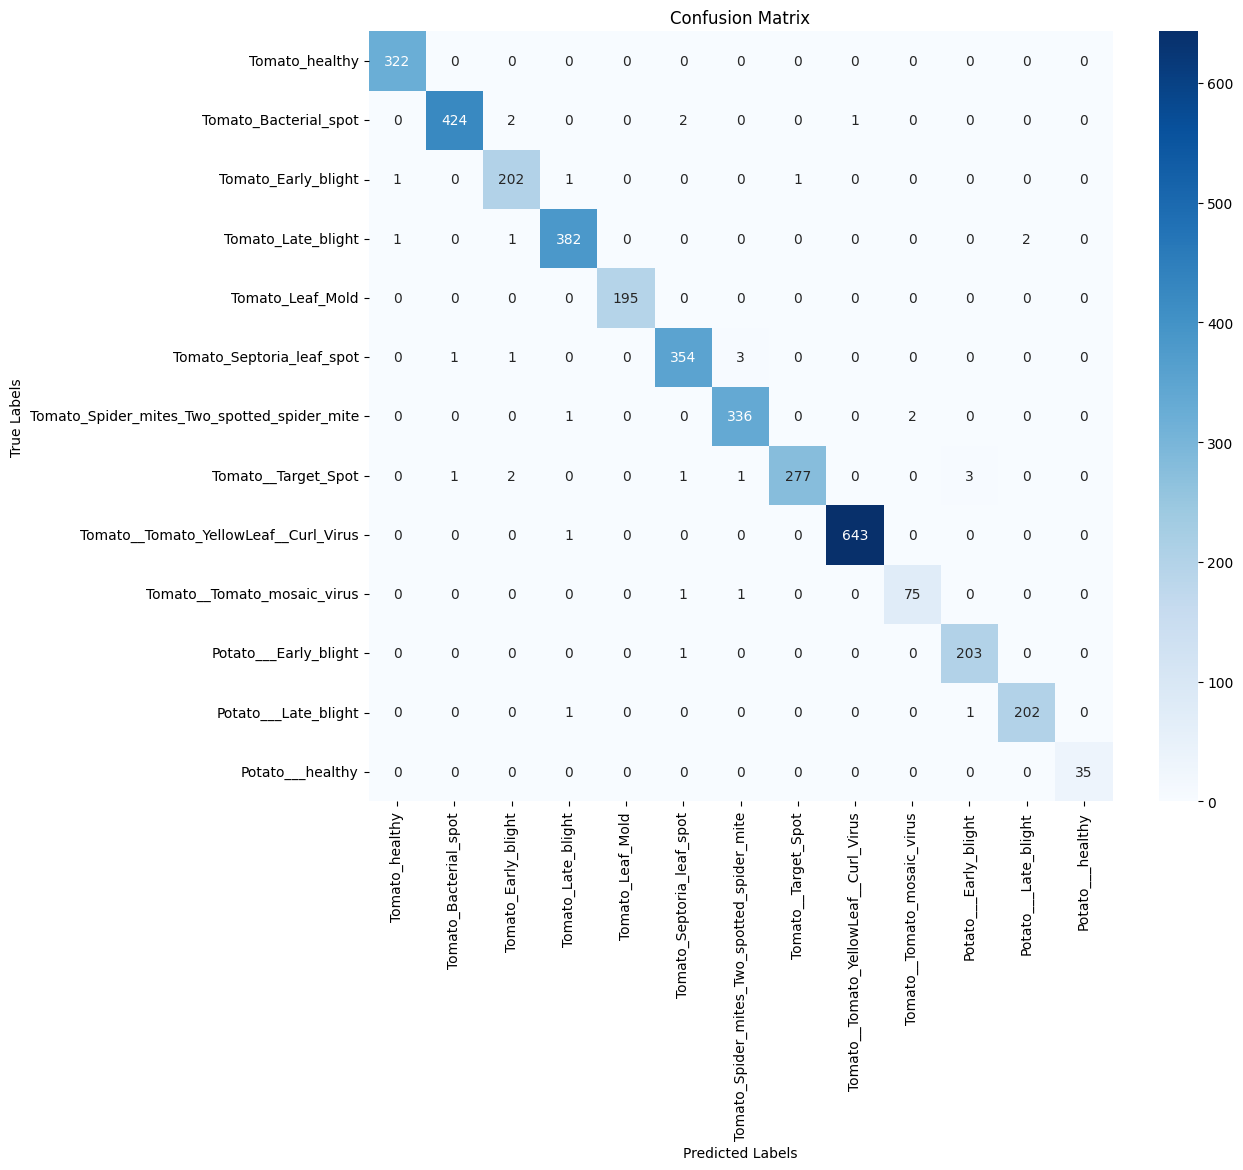


📑 Classification Report (Precision, Recall, F1-score):

                                             precision    recall  f1-score   support

                             Tomato_healthy       0.99      1.00      1.00       322
                      Tomato_Bacterial_spot       1.00      0.99      0.99       429
                        Tomato_Early_blight       0.97      0.99      0.98       205
                         Tomato_Late_blight       0.99      0.99      0.99       386
                           Tomato_Leaf_Mold       1.00      1.00      1.00       195
                  Tomato_Septoria_leaf_spot       0.99      0.99      0.99       359
Tomato_Spider_mites_Two_spotted_spider_mite       0.99      0.99      0.99       339
                        Tomato__Target_Spot       1.00      0.97      0.98       285
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      1.00      1.00       644
                Tomato__Tomato_mosaic_virus       0.97      0.97      0.97        77
       

In [17]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# VALIDATION LOOP
# =========================
model.eval()
all_preds = []
all_labels = []
val_running_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# =========================
# VALIDATION METRICS
# =========================
val_loss = val_running_loss / len(val_loader)
val_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"\n📊 Validation Loss: {val_loss:.4f}")
print(f"🎯 Validation Accuracy: {val_accuracy:.2f}%")

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# =========================
# CLASSIFICATION REPORT (Precision, Recall, F1-score)
# =========================
report = classification_report(all_labels, all_preds, target_names=selected_classes)
print("\n📑 Classification Report (Precision, Recall, F1-score):\n")
print(report)


In [18]:
from PIL import Image
from torchvision import transforms

# Preprocessing function (same as validation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return val_transform(image).unsqueeze(0)  # Add batch dimension

# Prediction function
def predict(model, image_tensor, class_names):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor.to(device))
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]

# Example usage
image_tensor = preprocess_image("/content/drive/MyDrive/datasets/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG")
result = predict(model, image_tensor, selected_classes)
print("Predicted class:", result)


Predicted class: Tomato_healthy
